分光器で得た光強度 → Rd, Tt

【注意事項】

・Spectra Suiteソフトで得た光強度スペクトルをGoogle Driveにアップロードしてください

・Rd, Tt両方測定していることを前提としています

・光強度のtxtファイル名は次のように定めてください

（例）Rdダークネスの1回目：R_1_D.txt、Ttサンプルの3回目：T_3_S.txt

・#.txt探索で適切に読み込めているか確認してください

・Google Colabのパスは '/content/drive/MyDrive/自分で作成したフォルダ'


In [1]:
# from google.colab import drive
# drive.mount('/content/drive')

Mounted at /content/drive


In [5]:
import glob
import os
import re
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import openpyxl as px

In [4]:
pip install openpyxl

Note: you may need to restart the kernel to use updated packages.


In [7]:
#パスの指定

data_path   ='/Users/imani/Desktop/optical property/integration-sphere/main/Intensity'
result_path ='/Users/imani/Desktop/optical property/integration-sphere/main/Rd_Tt'

os.chdir(data_path)
print(os.getcwd())

c:\Users\imani\Desktop\optical property\integration-sphere\main\Intensity


In [9]:
#.txtを探索 

file_name = glob.glob('*.txt') 

pattern = re.compile(r'\d')
file_name  = sorted(sorted(file_name, key=lambda x : int(pattern.search(x).group())))

print('ファイル数は', int(len(file_name)))

if int(len(file_name)) % 6 == 0:        #R, T同時に測定してますよね？
    measurement_num = int(len(file_name))//6
    print('測定回数は', measurement_num) 
else:
    print('.txtの数が不適切です。このコードを用いてR, Tを計算できません')

print(file_name)

'''出力したリストでR→Tの順、それぞれ数字順で、その中はB→D→Sでファイルが並んでいることを確認すること'''


ファイル数は 18
測定回数は 3
['R_1_B_MAYP1165941__0__19-59-02-991.txt', 'R_1_D_MAYP1165941__0__20-00-02-986.txt', 'R_1_S_MAYP1165941__0__19-57-57-997.txt', 'R_2_B_MAYP1165941__0__20-06-12-952.txt', 'R_2_D_MAYP1165941__0__20-05-42-954.txt', 'R_2_S_MAYP1165941__1__20-04-32-961.txt', 'R_3_B_MAYP1165941__1__20-12-22-918.txt', 'R_3_D_MAYP1165941__0__20-14-22-907.txt', 'R_3_S_MAYP1165941__1__20-09-52-932.txt', 'T_1_B_MAYP1165941__0__19-50-53-036.txt', 'T_1_D_MAYP1165941__0__19-49-53-042.txt', 'T_1_S_MAYP1165941__2__19-57-18-001.txt', 'T_2_B_MAYP1165941__0__20-01-17-979.txt', 'T_2_D_MAYP1165941__0__20-02-02-975.txt', 'T_2_S_MAYP1165941__0__20-03-52-965.txt', 'T_3_B_MAYP1165941__0__20-08-02-942.txt', 'T_3_D_MAYP1165941__0__20-07-32-944.txt', 'T_3_S_MAYP1165941__0__20-09-12-935.txt']


'出力したリストでR→Tの順、それぞれ数字順で、その中はB→D→Sでファイルが並んでいることを確認すること'

In [10]:
#データ取得

def Fetch_Data(R_or_T, bds):      #引数　R_or_T → R:0,T:1  bds → b(brightness):0, d(darkness)→1, s(sample)→2
    
    for i in range(measurement_num):
        with open(file_name[R_or_T*3*measurement_num+3*i+bds], encoding='utf_8', errors='ignore') as f:
            lines = f.readlines()

        if i == 0:
            data = np.zeros((2, measurement_num, len(lines)-15))
        
        #measured values
        for j in range(14, len(lines)-1):
            item = (lines[j].rstrip('\n')).split('\t')
            data[0,i,j-14], data[1,i,j-14] = float(item[0]), float(item[1])
    return data

R_b, R_d, R_s = Fetch_Data(0, 0), Fetch_Data(0, 1), Fetch_Data(0, 2) 
T_b, T_d, T_s = Fetch_Data(1, 0), Fetch_Data(1, 1), Fetch_Data(1, 2)

print(np.array(R_b).shape)
print(np.array(R_b))


(2, 3, 2067)
[[[ 199.712  200.181  200.65  ... 1111.003 1111.413 1111.823]
  [ 199.712  200.181  200.65  ... 1111.003 1111.413 1111.823]
  [ 199.712  200.181  200.65  ... 1111.003 1111.413 1111.823]]

 [[ 842.62  -156.12    31.1   ...   -5.39    -3.43    -5.07 ]
  [ 843.22  -156.8     29.74  ...   -5.2     -3.51    -4.49 ]
  [ 845.49  -156.76    30.9   ...   -5.8     -3.54    -4.55 ]]]


In [11]:
#Rd, Tt計算

def RT_Cal(Brightness, Darkness, Sample):
    
    data = np.zeros((measurement_num, R_b.shape[2]))

    for i in range(measurement_num):
        for j in range(R_b.shape[2]):
            
            if Sample[1,i,j] - Brightness[1,i,j] == 0:
                data[i,j] = 0
            elif Brightness[1,i,j]-Darkness[1,i,j] == 0:          #0で割るようなことがあったときにエラーが出ないように
                data[i,j] = 1
            else:
                data[i,j] = round((Sample[1,i,j]-Darkness[1,i,j])/(Brightness[1,i,j]-Darkness[1,i,j]), 5)
    return data

Rd_spectra = RT_Cal(R_b, R_d, R_s)
Tt_spectra = RT_Cal(T_b, T_d, T_s)

print(np.array(Rd_spectra).shape)
print(np.array(Rd_spectra))


(3, 2067)
[[ 0.81818  1.14925  0.15    ...  1.34615  1.      -7.25   ]
 [ 0.33333 -0.33333  0.40741 ...  1.37838  2.25    -0.36842]
 [ 2.2      1.48235  0.07692 ...  0.18367 -0.325   -5.33333]]


In [12]:
#平均値, 標準偏差

def Get_Mean_Std(data):
    ave = np.mean(data, axis=0).round(5)
    std = np.std(data, axis=0).round(5)
    return ave, std

Rd_ave_spectrum, Rd_std_spectrum = Get_Mean_Std(Rd_spectra)
Tt_ave_spectrum, Tt_std_spectrum = Get_Mean_Std(Tt_spectra)

R_b_ave, R_d_ave, R_s_ave = Get_Mean_Std(R_b[1])[0], Get_Mean_Std(R_d[1])[0], Get_Mean_Std(R_s[1])[0]
T_b_ave, T_d_ave, T_s_ave = Get_Mean_Std(T_b[1])[0], Get_Mean_Std(T_d[1])[0], Get_Mean_Std(T_s[1])[0]

print(np.array(R_b_ave).shape, np.array(Rd_ave_spectrum).shape)
print(np.array(R_b_ave))
print(np.array(Tt_ave_spectrum))


(2067,) (2067,)
[ 843.77667 -156.56      30.58    ...   -5.46333   -3.49333   -4.70333]
[ 2.53632 -6.46547  0.1157  ...  0.68793 16.80029 -0.20321]


In [13]:
#対象とする波長域の選択

set_wlen_min, set_wlen_max = 400, 700     #←入力してください
target = 'all'                            #IMCのinput. 例えば測定がN=3のとき，平均のR,Tを解析するか(average), N=3全てのR, Tを解析するか(all)

def GetNearestValue(list, num):
    idx = np.abs(np.asarray(list) - num).argmin()
    return list[idx], idx

wavelength = R_b[0,0,:]
min_val, max_val   = GetNearestValue(wavelength, set_wlen_min), GetNearestValue(wavelength, set_wlen_max)
list_min, list_max = min_val[1], max_val[1]
    
print(min_val, max_val) 
print(list_min, list_max)


(400.047, 432) (700.06, 1099)
432 1099


In [14]:
#外れ値除去 (A14)

'''
分光器の感度がおかしい波長のデータを削除する
'''

Outliner = 'Yes'                                                 #外れ値除去 する:Yes, しない:No
Outliner_WL_A14 = ['474.27', '548.23', '554.55', '607.13']       #←決まった値です

def Delete_Outliner(data, data_type):
    index = [i for i in range(len(wavelength)) for WL in Outliner_WL_A14 if wavelength[i] == float(WL)]

    if data_type == 0:                               #平均
        new_data = np.delete(data, index)
    else:                                            #各測定
        new_data = np.delete(data, index, axis=1)   
    return new_data

if Outliner == 'Yes':
    Rd_spectra = Delete_Outliner(Rd_spectra, 1)
    Tt_spectra = Delete_Outliner(Tt_spectra, 1)

    Rd_ave_spectrum, Rd_std_spectrum = Delete_Outliner(Rd_ave_spectrum, 0), Delete_Outliner(Rd_std_spectrum, 0)
    Tt_ave_spectrum, Tt_std_spectrum = Delete_Outliner(Tt_ave_spectrum, 0), Delete_Outliner(Tt_std_spectrum, 0)

    #波長も更新する
    wavelength = Delete_Outliner(wavelength, 0)

print(Rd_spectra.shape)
print(Rd_ave_spectrum.shape)

(3, 2067)
(2067,)


データ出力

In [18]:
#xlsx出力

def Title(sheet_name, label_title):         #sheet → Rd_data, Tt_data
    if sheet_name != sheet3:
        for i in range(3):
            sheet_name.cell(1, 0*(measurement_num+3)+1).value = label_title +'_brightness'
            sheet_name.cell(1, 1*(measurement_num+3)+1).value = label_title +'_darkness'
            sheet_name.cell(1, 2*(measurement_num+3)+1).value = label_title +'_sample'
            sheet_name.cell(2, i*(measurement_num+3)+1).value = 'Wavelength[nm]'
            sheet_name.cell(2, i*(measurement_num+3)+measurement_num+2).value = 'Average[count]'
        
    else:
        for j in range(2):
            sheet_name.cell(1, 1).value                 = 'Diffuse Reflectance [-]'
            sheet_name.cell(1, measurement_num+5).value = 'Total Transmittance [-]'
            sheet_name.cell(2, j*(measurement_num+4)+1).value                 = 'Wavelength[nm]'
            sheet_name.cell(2, j*(measurement_num+4)+measurement_num+2).value = 'Average[-]'


def Input_LightIntensity(sheet, data, average, BDS):
    for k in range(measurement_num):
        for l in range(0, list_max-list_min):
            sheet.cell(2, BDS*(measurement_num+3)+k+2).value   = k+1
            sheet.cell(l+3, BDS*(measurement_num+3)+1).value   = wavelength[l+list_min]
            sheet.cell(l+3, BDS*(measurement_num+3)+k+2).value = data[1, k, l+list_min]
            sheet.cell(l+3, BDS*(measurement_num+3)+measurement_num+2).value = average[l+list_min]


def Input_RT(sheet, data, average, R_or_T):      #R→0, T→1
    for m in range(measurement_num):
        for n in range(0, list_max-list_min):
            sheet.cell(2, R_or_T*(measurement_num+4)+m+2).value   = m+1
            sheet.cell(n+3, R_or_T*(measurement_num+4)+1).value   = wavelength[n+list_min]
            sheet.cell(n+3, R_or_T*(measurement_num+4)+m+2).value = data[m, n+list_min]
            sheet.cell(n+3, R_or_T*(measurement_num+4)+measurement_num+2).value = average[n+list_min]


wb = px.Workbook()
sheet1 = wb.active
sheet1.title = 'Rd_data'
sheet2 = wb.create_sheet(title='Tt_data')
sheet3 = wb.create_sheet(title='Result')

wb.active = wb.sheetnames.index('Rd_data')
Title(sheet1, 'Rd')
Input_LightIntensity(sheet1, R_b, R_b_ave, 0)
Input_LightIntensity(sheet1, R_d, R_d_ave, 1)
Input_LightIntensity(sheet1, R_s, R_s_ave, 2)

wb.active = wb.sheetnames.index('Tt_data')
Title(sheet2, 'Tt')
Input_LightIntensity(sheet2, T_b, T_b_ave, 0)
Input_LightIntensity(sheet2, T_d, T_d_ave, 1)
Input_LightIntensity(sheet2, T_s, T_s_ave, 2)

wb.active = wb.sheetnames.index('Result')
Title(sheet3, 'hoge')
Input_RT(sheet3, Rd_spectra, Rd_ave_spectrum, 0)
Input_RT(sheet3, Tt_spectra, Tt_ave_spectrum, 1)

wb.active = wb.sheetnames.index('Rd_data')
wb.save('{:}/Rd_Tt_result.xlsx'.format(result_path))             
wb.close()

In [20]:
#IMC input用csv出力

'''
回数が多い場合は複数のcsvに分けた方が良い
'''

if target == 'average':
    R_T_data = np.c_[wavelength[list_min : list_max], Rd_ave_spectrum[list_min : list_max], Tt_ave_spectrum[list_min : list_max]]
elif target == 'all':
    R_T_data = np.c_[np.tile(wavelength[list_min : list_max], measurement_num), Rd_spectra[:, list_min : list_max].flatten(), Tt_spectra[:, list_min : list_max].flatten()]
else:
    print('Invalid')

data_df = pd.DataFrame(R_T_data, columns=['Wavelength [nm]', 'Rd [-]', 'Tt [-]'])
data_df.to_csv('{:}/Rd_Tt_IMC_input.csv'.format(result_path), index=False)

print('IMC解析対象 :', target)
print('IMC解析対象データ数 :', len(R_T_data))


IMC解析対象 : all
IMC解析対象データ数 : 2001


スペクトル描画

In [21]:
plt.rcParams['font.size'] = 16

In [22]:
#グラフ描画（定義1）

def MakeFigure1(RT_or_else, y_data, y_error, y_min, y_max, img_name):
    fig = plt.figure(figsize=(6, 4))
    plt.xlabel('Wavelength [nm]')
    plt.xlim(set_wlen_min, set_wlen_max)
    plt.ylim(y_min, y_max)
    plt.xticks(np.arange(set_wlen_min, set_wlen_max+1, 100))
    
    if RT_or_else == 0:
        plt.ylabel('Diffuse reflectance [-]')
    elif RT_or_else == 1:
        plt.ylabel('Total Transmittance [-]')
    else:
        plt.ylabel('Light intensity [count]')
    
    plt.errorbar(wavelength[list_min:list_max], y_data[list_min:list_max], yerr=y_error[list_min:list_max],
                 markersize=2, ecolor='powderblue', capsize=0.1, fmt='o')
    
    plt.text(set_wlen_min+(set_wlen_max-set_wlen_min)*0.95, y_min+(y_max-y_min)*0.95,
             'N = {:}'.format(measurement_num),
             horizontalalignment='right', verticalalignment='top')
    plt.show()

    fig.savefig('{:}/{:}.jpeg'.format(result_path, img_name), dpi=600, bbox_inches='tight')
        

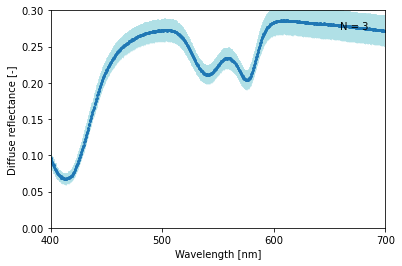

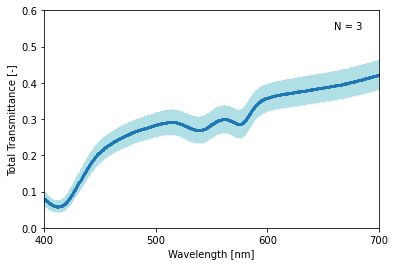

In [23]:
#Rd, Ttスペクトル表示

#Rd
MakeFigure1(0, Rd_ave_spectrum, Rd_std_spectrum, 0.0, 0.3, 'IMG_Rd_ave_spectrum')

#Tt
MakeFigure1(1, Tt_ave_spectrum, Tt_std_spectrum, 0.0, 0.6, 'IMG_Tt_ave_spectrum')


In [24]:
#グラフ描画（定義2）

'''
色変えたかったら指定して
https://pythondatascience.plavox.info/matplotlib/%E8%89%B2%E3%81%AE%E5%90%8D%E5%89%8D
'''
colorlist = ['indianred', 'darkgoldenrod', 'mediumseagreen', 'steelblue', 'palevioletred', 'slateblue', 'darkslategray']


def MakeFigure2(RT_or_else, y_data, y_min, y_max, loc_1, loc_2, img_name):
    fig = plt.figure(figsize=(6, 4))
    plt.xlabel('Wavelength [nm]')
    plt.xlim(set_wlen_min, set_wlen_max)
    plt.ylim(y_min, y_max)
    plt.xticks(np.arange(set_wlen_min, set_wlen_max+1, 100))
    
    if RT_or_else == 0:
        plt.ylabel('Diffuse reflectance [-]')
    elif RT_or_else == 1:
        plt.ylabel('Total transmittance [-]')
    else:
        plt.ylabel('Light intensity [count]')
        
    for i in range(measurement_num):
        plt.scatter(wavelength[list_min:list_max], y_data[i][list_min:list_max], s=1, c=colorlist[i], label=str(i+1))
        lg = plt.legend(bbox_to_anchor=loc_1, loc=loc_2, borderaxespad=0, fontsize=10)
        
    fig.savefig('{:}/{:}.jpeg'.format(result_path, img_name), dpi=600, bbox_inches='tight')


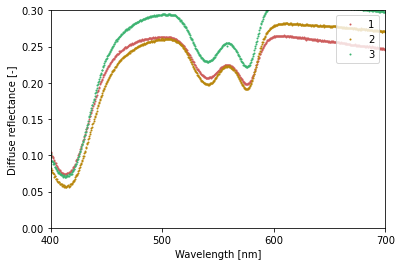

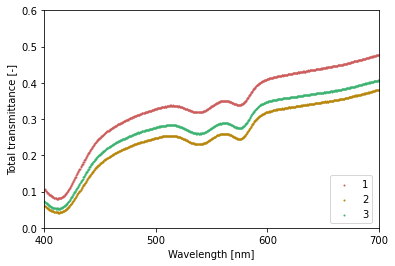

In [25]:
#Rd, Ttスペクトル比較

#Rd
MakeFigure2(0, Rd_spectra, 0.0, 0.3, (0.98, 0.98), 'upper right', 'Rd_spectra')

#Tt
MakeFigure2(1, Tt_spectra, 0.0, 0.6, (0.98, 0.02), 'lower right', 'Tt_spectra')


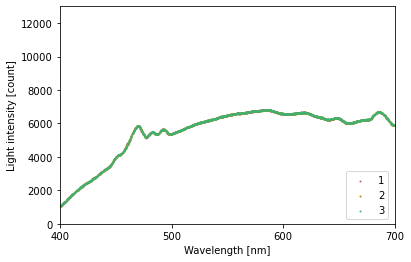

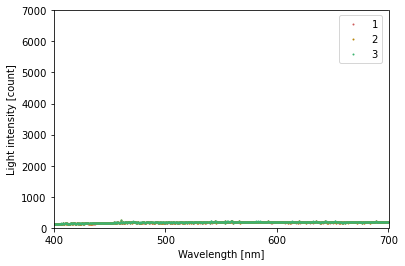

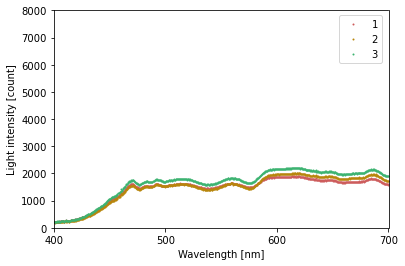

In [26]:
#光強度の種類ごとに表示(Rd)

MakeFigure2(2, R_b[1],  0, 13000, (0.98, 0.02), 'lower right', 'Rd_brightness')
MakeFigure2(2, R_d[1],  0, 7000, (0.98, 0.98), 'upper right', 'Rd_darkness')
MakeFigure2(2, R_s[1],  0, 8000, (0.98, 0.98), 'upper right', 'Rd_sample')


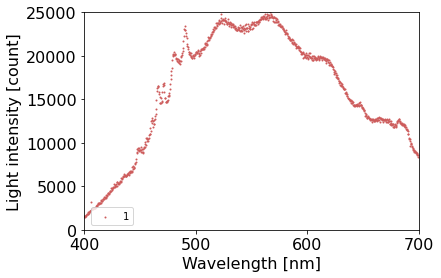

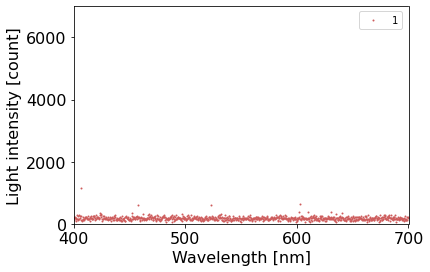

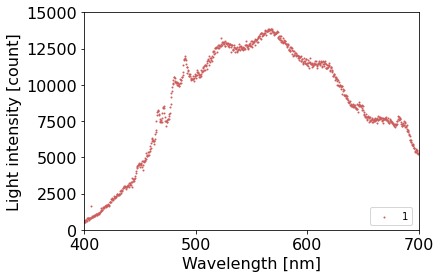

In [ ]:
#光強度の種類ごとに表示(Tt)

MakeFigure2(2, T_b[1],  0, 25000, (0.02, 0.02), 'lower left', 'Tt_brightness')
MakeFigure2(2, T_d[1],  0, 7000, (0.98, 0.98), 'upper right', 'Tt_darkness')
MakeFigure2(2, T_s[1],  0, 15000, (0.98, 0.02), 'lower right', 'Tt_sample')
